In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:
# Hàm tính toán IoU (Intersection over Union)
def compute_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

In [13]:
# Hàm thực hiện khớp mẫu cho từng kênh màu và trả về kết quả tổng hợp
def match_template_rgb(image, template, mask_rgb):
    # Tách kênh R, G, B cho ảnh và mẫu
    image_r, image_g, image_b = cv2.split(image)
    template_r, template_g, template_b = cv2.split(template)
    mask_r, mask_g, mask_b = cv2.split(mask_rgb)

    # Thực hiện khớp mẫu trên từng kênh màu
    result_r = cv2.matchTemplate(image_r, template_r, cv2.TM_SQDIFF_NORMED, mask=mask_r)
    result_g = cv2.matchTemplate(image_g, template_g, cv2.TM_SQDIFF_NORMED, mask=mask_g)
    result_b = cv2.matchTemplate(image_b, template_b, cv2.TM_SQDIFF_NORMED, mask=mask_b)

    # Kết hợp kết quả từ cả ba kênh
    return (result_r + result_g + result_b) / 3

In [14]:
# Hàm chính
def template_matching(image_path, template_path, threshold, iou_threshold=0.1):
    # Đọc ảnh và mẫu
    image = cv2.imread(image_path)
    template = cv2.imread(template_path)

    # Thay đổi kích thước mẫu nếu cần
    scale_factor = 1
    new_width = int(template.shape[1] * scale_factor)
    new_height = int(template.shape[0] * scale_factor)
    template = cv2.resize(template, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Tạo mặt nạ nhị phân từ mẫu và nhân bản nó cho các kênh RGB
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(template_gray, 240, 255, cv2.THRESH_BINARY_INV)
    mask_rgb = cv2.merge([mask, mask, mask])

    # Khớp mẫu và tính kết quả
    result = match_template_rgb(image, template, mask_rgb)

    # Tìm các vị trí có giá trị khớp dưới ngưỡng đã định
    locations = np.where(result <= threshold)

    # Lưu danh sách các hộp bao quanh các vùng khớp
    bounding_boxes = []
    template_h, template_w = template.shape[:2]
    for pt in zip(*locations[::-1]):
        top_left = pt
        bounding_boxes.append((top_left[0], top_left[1], template_w, template_h))

    # Gộp các hộp bị chồng lấn dựa trên ngưỡng IoU
    merged_boxes = []
    for box in bounding_boxes:
        should_merge = False
        for merged_box in merged_boxes:
            if compute_iou(box, merged_box) > iou_threshold:
                should_merge = True
                break
        if not should_merge:
            merged_boxes.append(box)

    # Vẽ hình chữ nhật bao quanh các vùng khớp
    image_copy = image.copy()
    for box in merged_boxes:
        top_left = (box[0], box[1])
        bottom_right = (box[0] + box[2], box[1] + box[3])
        cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)

    # In số lượng vùng khớp sau khi gộp
    print(f"Số lượng vùng khớp tìm thấy (sau khi gộp): {len(merged_boxes)}")

    # Chuyển ảnh sang RGB để hiển thị bằng matplotlib
    image_copy_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

    # Hiển thị ảnh với các vùng khớp
    plt.figure(figsize=(10, 10))
    plt.imshow(image_copy_rgb)
    plt.title("Kết quả khớp mẫu")
    plt.axis('off')
    plt.show()

Số lượng vùng khớp tìm thấy (sau khi gộp): 8


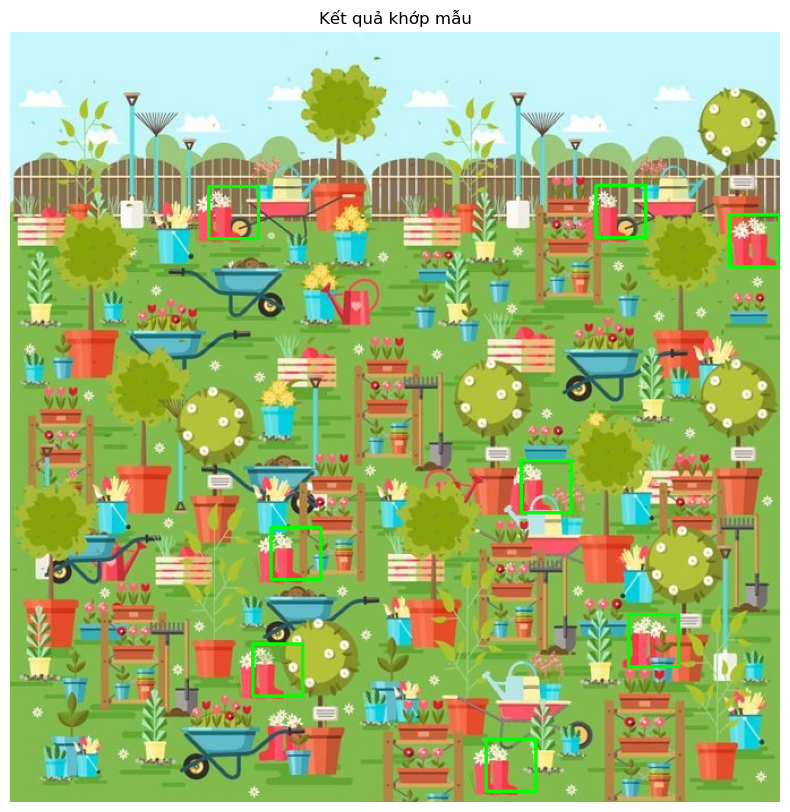

In [15]:
# Gọi hàm chính với đường dẫn tới ảnh và mẫu
template_matching('pair_boot.jpg', 'objects/1_boot.jpg',0.095)


Số lượng vùng khớp tìm thấy (sau khi gộp): 77


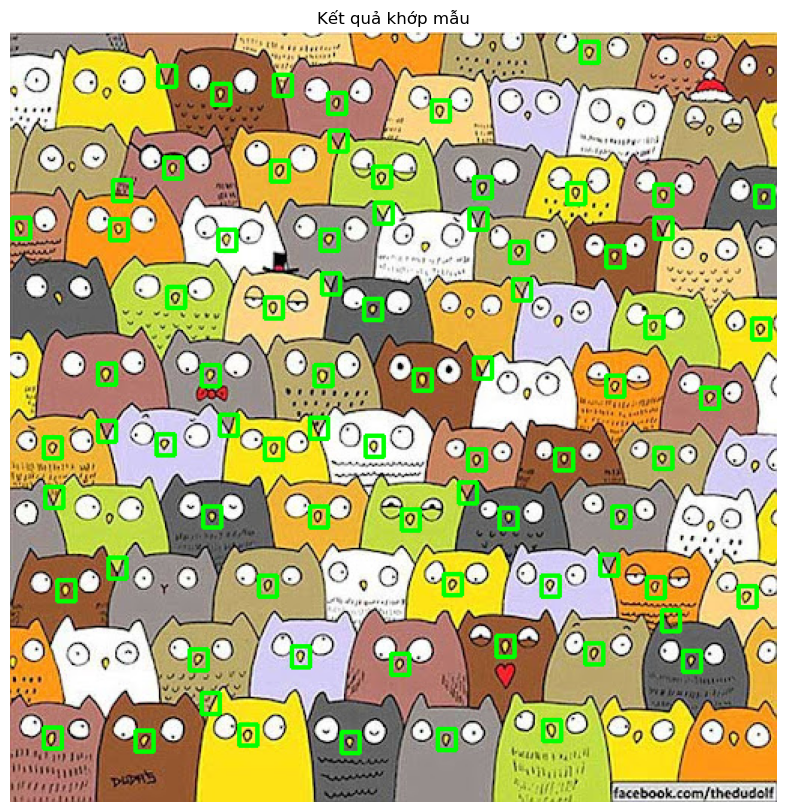

In [25]:
# Gọi hàm chính với đường dẫn tới ảnh và mẫu
template_matching('cat.jpg', 'objects/cat_mouth.jpg',0.4)


Số lượng vùng khớp tìm thấy (sau khi gộp): 14


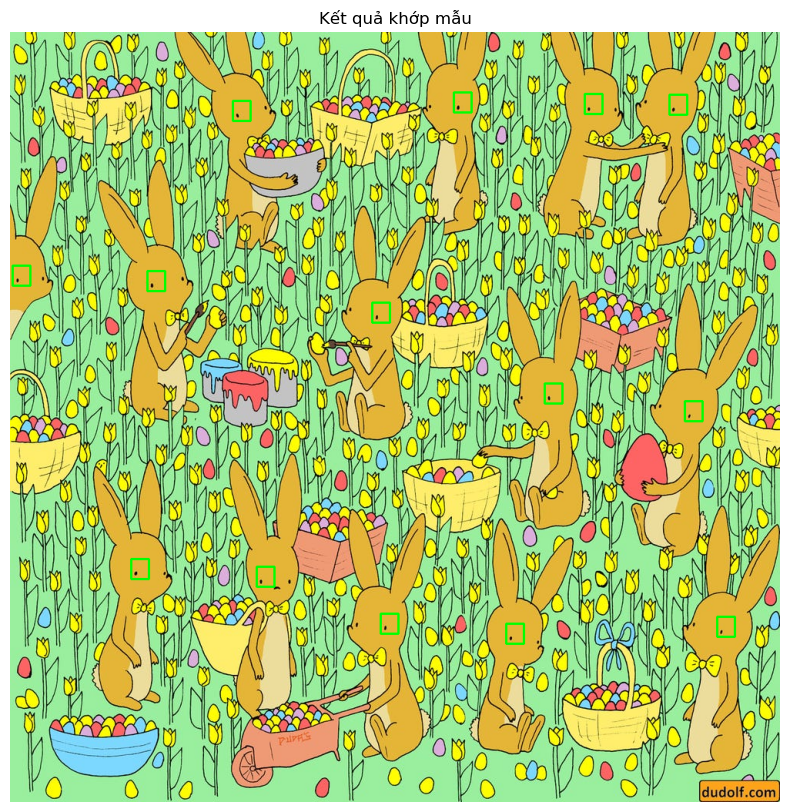

In [19]:
# Gọi hàm chính với đường dẫn tới ảnh và mẫu
template_matching('rabbit.jpeg', 'objects/rabbit_eye.jpeg', 0.02)


Số lượng vùng khớp tìm thấy (sau khi gộp): 48


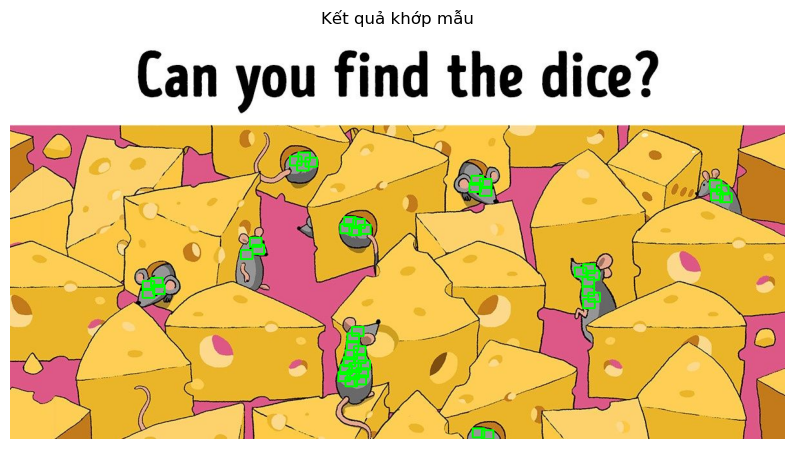

In [24]:
# Gọi hàm chính với đường dẫn tới ảnh và mẫu
template_matching('mouse.jpg', 'objects/mouse_fur.jpg', 0.01)


Number of matches found (after grouping nearby boxes): 9


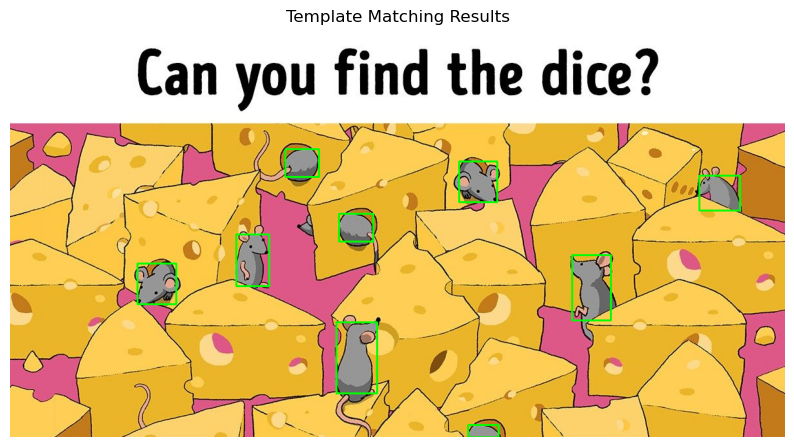

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to check if two bounding boxes are in each other's vicinity
def are_boxes_near(box1, box2, vicinity_threshold):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Compute the center coordinates of both boxes
    center1_x = x1 + w1 / 2
    center1_y = y1 + h1 / 2
    center2_x = x2 + w2 / 2
    center2_y = y2 + h2 / 2

    # Compute the distance between the centers
    distance = np.sqrt((center1_x - center2_x) ** 2 + (center1_y - center2_y) ** 2)

    return distance <= vicinity_threshold

# Template Matching function
def template_matching(image_path, template_path, threshold=0.095, iou_threshold=0.1, vicinity_threshold=50):
    # Load input images in color (RGB)
    image = cv2.imread(image_path)
    template = cv2.imread(template_path)

    # Resize the template if necessary
    scale_factor = 1
    template = cv2.resize(template, (int(template.shape[1] * scale_factor), int(template.shape[0] * scale_factor)), interpolation=cv2.INTER_AREA)

    # Create a binary mask for the template
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(template_gray, 240, 255, cv2.THRESH_BINARY_INV)
    mask_rgb = cv2.merge([mask] * 3)  # Replicate the mask for all 3 channels

    # Get template dimensions
    template_h, template_w = template.shape[:2]

    # Split the image and template into R, G, and B channels
    image_r, image_g, image_b = cv2.split(image)
    template_r, template_g, template_b = cv2.split(template)
    mask_r, mask_g, mask_b = cv2.split(mask_rgb)

    # Perform template matching on each RGB channel
    result_r = cv2.matchTemplate(image_r, template_r, cv2.TM_SQDIFF_NORMED, mask=mask_r)
    result_g = cv2.matchTemplate(image_g, template_g, cv2.TM_SQDIFF_NORMED, mask=mask_g)
    result_b = cv2.matchTemplate(image_b, template_b, cv2.TM_SQDIFF_NORMED, mask=mask_b)

    # Combine the results (average for RGB channels)
    result = (result_r + result_g + result_b) / 3

    # Find all locations where the match result is below the threshold
    locations = np.where(result <= threshold)

    # Create a list of bounding boxes for all matches
    bounding_boxes = [(pt[0], pt[1], template_w, template_h) for pt in zip(*locations[::-1])]

    # Group bounding boxes that are near each other
    grouped_boxes = []
    for box in bounding_boxes:
        found_group = False
        for group in grouped_boxes:
            if any(are_boxes_near(box, other_box, vicinity_threshold) for other_box in group):
                group.append(box)
                found_group = True
                break
        if not found_group:
            grouped_boxes.append([box])

    # Merge each group of bounding boxes into a single box
    merged_boxes = []
    for group in grouped_boxes:
        if len(group) == 1:
            merged_boxes.append(group[0])
        else:
            x_coords = [b[0] for b in group]
            y_coords = [b[1] for b in group]
            widths = [b[2] for b in group]
            heights = [b[3] for b in group]
            
            # Compute the merged bounding box around all boxes in the group
            top_left_x = min(x_coords)
            top_left_y = min(y_coords)
            bottom_right_x = max([x + w for x, w in zip(x_coords, widths)])
            bottom_right_y = max([y + h for y, h in zip(y_coords, heights)])
            
            merged_width = bottom_right_x - top_left_x
            merged_height = bottom_right_y - top_left_y
            
            merged_boxes.append((top_left_x, top_left_y, merged_width, merged_height))

    # Draw rectangles around all merged matches
    image_copy = image.copy()
    for box in merged_boxes:
        top_left = (box[0], box[1])
        bottom_right = (box[0] + box[2], box[1] + box[3])
        cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)

    # Print the number of merged matches found
    print(f"Number of matches found (after grouping nearby boxes): {len(merged_boxes)}")

    # Convert BGR to RGB for displaying with matplotlib
    image_copy_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

    # Display the image with the matched regions
    plt.figure(figsize=(10, 10))
    plt.imshow(image_copy_rgb)
    plt.title("Template Matching Results")
    plt.axis('off')
    plt.show()

# Call the function
template_matching('mouse.jpg', 'objects/mouse_fur.jpg')
